In [1]:
import numpy as np
import json
from matplotlib import pyplot as plt

In [2]:
with open('data/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)
with open('data/score_data.json', 'r') as infile:
    scoring_data_1 = json.load(infile)
with open('data/score_data_2.json', 'r') as infile:
    scoring_data_2 = json.load(infile)
with open('data/score_vs_energy.json', 'r') as infile:
    randomized = json.load(infile)

In [3]:
molecules = list(scoring_data_1.keys())
print(molecules)

['HCN_STO-3G_SINGLET', 'HCl_STO-3G_SINGLET', 'F2_STO-3G_SINGLET', 'N2_STO-3G_SINGLET', 'SiH4_STO-3G_SINGLET', 'H2S_STO-3G_SINGLET', 'CH4_STO-3G_SINGLET', 'HOOH_STO-3G_SINGLET', 'H2O_STO-3G_SINGLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'BeH+_STO-3G_SINGLET', 'NH3_STO-3G_SINGLET', 'NaCl_STO-3G_SINGLET', 'O3_STO-3G_SINGLET', 'O2_STO-3G_SINGLET', 'C2H5F_STO-3G_SINGLET', 'C2H6_STO-3G_SINGLET', 'CO2_STO-3G_SINGLET', 'CH3COCH3_STO-3G_SINGLET', 'CH3OCH3_STO-3G_SINGLET', 'CHONH2_STO-3G_SINGLET', 'CH3CHOHCH3_STO-3G_SINGLET', 'CH3CHO_STO-3G_SINGLET', 'CH3CN_STO-3G_SINGLET', 'CH3OH_STO-3G_SINGLET', 'CH3CH2OH_STO-3G_SINGLET', 'CH3CH2NH2_STO-3G_SINGLET', 'CH3NHCH3_STO-3G_SINGLET', 'H2O_cc-pVDZ_SINGLET', 'H2O_6-31g_SINGLET']


In [4]:
speciesname = 'CH3CHOHCH3_STO-3G_SINGLET'
data = scoring_data_1[speciesname]
n_qubits = data['n_qubits_post_taper']
hf_energy = data['hf_energy']
mp2_energy = data['mp2_energy']
ccsd_energy = data['ccsd_energy']
fci_energy = data['fci_energy']
energies = data['cs_vqe_energies']
scores = data['stabilizer_score']

In [5]:
plot_mols = [mol for mol in molecules if scoring_data_1[mol]['fci_energy'] is not None]
len(plot_mols)

21

# Randomized bases

In [6]:
rand_molecules = list(randomized.keys())
print(rand_molecules)

['Be_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'BeH2_STO-3G_SINGLET', 'H2O_STO-3G_SINGLET', 'OH-_STO-3G_SINGLET', 'HeH+_6-311G_SINGLET']


In [7]:
n_grids = len(rand_molecules)
print(n_grids)

def factor_near_square(x: int):
    a = int(np.sqrt(x))
    b = x/a
    while b-int(b)!=0:
        a+=1
        b = x/a
    return int(a),int(b)

7


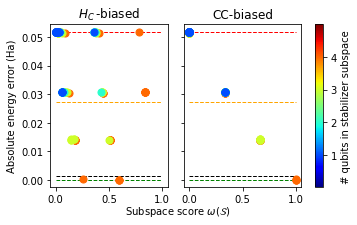

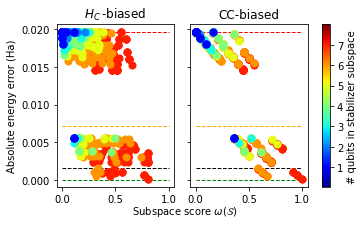

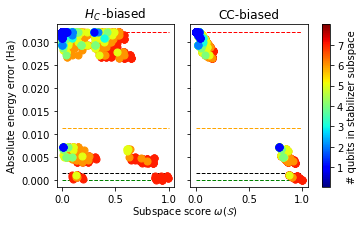

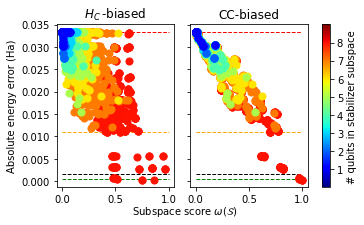

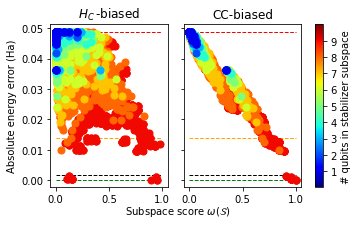

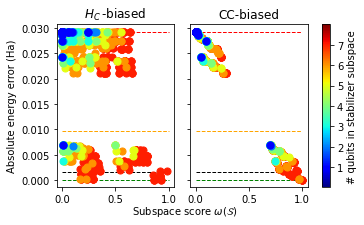

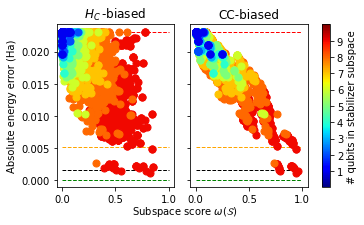

In [12]:
from matplotlib.pyplot import Normalize


for index,speciesname in enumerate(rand_molecules):
    
    fig,axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(5,3),
                           gridspec_kw={'width_ratios': [10, 10, 1]})
        
    data = randomized[speciesname]
    n_qubits = data['n_qubits_post_taper']
    n_qubits_full = data['n_qubits_pre_taper']
    hf_energy = data['hf_energy']
    mp2_energy = data['mp2_energy']
    ccsd_energy = data['ccsd_energy']
    fci_energy = data['fci_energy']
    ham_ucc_nrg = data['ham_score_ucc_score_cs_energy']
    increments=[]
    
    for n_sim_qubits,results in ham_ucc_nrg.items():
        ratio = int(n_sim_qubits)/n_qubits
        increments.append(ratio)
        c = plt.cm.jet(ratio)
        X_ham, X_ucc, X_nrg = zip(*results)
        X_ham = np.array(X_ham)
        X_ucc = np.array(X_ucc)
        Y_nrg = np.array(X_nrg) - fci_energy
        
        axes[0].scatter(np.square(X_ham),Y_nrg,marker='o',color=c,s=50,zorder=1,alpha=1)
        axes[1].scatter(np.square(X_ucc),Y_nrg,marker='o',color=c,s=50,zorder=1,alpha=1)
    
    def plot_lines(axis):
        axis.hlines(hf_energy-fci_energy, 0, 1, ls='--', lw=1, color='red', zorder=0, label='HF energy')
        axis.hlines(mp2_energy-fci_energy, 0, 1, ls='--', lw=1, color='orange', zorder=0, label='MP2 energy')
        axis.hlines(ccsd_energy-fci_energy, 0, 1, ls='--', lw=1, color='green', zorder=0, label='CCSD energy')
        axis.hlines(0.0016, 0, 1, ls='--', lw=1, color='black', zorder=0, label='Chemical accuracy')
    plot_lines(axes[0])
    plot_lines(axes[1])
    
    keys = list(ham_ucc_nrg.keys())
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(), cmap='jet'), 
                         ax=axes[2], label='# qubits in stabilizer subspace', ticks=increments, fraction=1.2)
    cbar.ax.set_yticklabels(keys)

    axes[0].set_title('$H_{C}\,$-biased')
    axes[1].set_title('CC-biased')
    axes[0].set_ylabel('Absolute energy error (Ha)')
    axes[1].set_xlabel('Subspace score $\omega(\mathcal{S})$')
    axes[1].xaxis.set_label_coords(-0.05,-0.1)
    axes[2].set_visible(False)    
    
    filename = f'plots/{speciesname}_score_vs_energy.png'
    fig.savefig(filename, dpi=300, bbox_inches='tight')

In [ ]:
keys = list(data.keys())
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(), cmap='jet'), 
                     ax=axis, label='# qubits in stabilizer subspace', ticks=increments)#, fraction=0.78)
cbar.ax.set_yticklabels(keys)

axis.set_xlabel('Stabilizer subspace score')
axis.set_ylabel('$\omega(\mathcal{S})$')

axis.hlines(hf_energy-fci_energy, 0, 1, ls='--', lw=1, color='red', zorder=0, label='HF energy')
axis.hlines(mp2_energy-fci_energy, 0, 1, ls='--', lw=1, color='orange', zorder=0, label='MP2 energy')
axis.hlines(ccsd_energy-fci_energy, 0, 1, ls='--', lw=1, color='green', zorder=0, label='CCSD energy')
axis.hlines(0.0016, 0, 1, ls='--', lw=1, color='black', zorder=0, label='Chemical accuracy')

    
    c = plt.cm.jet(index/len(plot_mols))
    X = np.arange(len(scores))+1
    score_axis.plot(X,scores, color=c, marker='+', label=f'{n_qubits_full}q {name}')
    score_axis.vlines(scored_1+1, 0, 1, color=c, ls='--', lw=1)

# Plot the small molecules with their CS-VQE errors

In [81]:
def plot_energy_vs_score(speciesname, energy_axis):
    data_1 = scoring_data_1[speciesname]
    data_2 = scoring_data_2[speciesname]
    
    n_qubits = data_2['n_qubits_post_taper']
    n_qubits_full = data_2['n_qubits_pre_taper']
    fci_energy = data_2['fci_energy']
    hf_error = data_2['hf_energy'] - fci_energy
    mp2_error = data_2['mp2_energy'] - fci_energy
    ccsd_error = data_2['ccsd_energy'] - fci_energy
    
    X = np.arange(1, n_qubits)
    Y_scores = np.array(data_2['stabilizer_score'])
    Y_energy = np.array(data_2['cs_vqe_energies'])[:15] - fci_energy
    Y_energy_1 = np.array(data_1['cs_vqe_energies'])[:15] - fci_energy
   
    
    energy_axis.hlines(hf_error,  1, X[-1], ls='--', color='red',    label='HF energy')
    energy_axis.hlines(mp2_error, 1, X[-1], ls='--', color='orange', label='MP2 energy')
    energy_axis.hlines(ccsd_error,1, X[-1], ls='--', color='green',  label='CCSD energy')
    energy_axis.hlines(0.0016,    1, X[-1], ls='--', color='black',  label='Chemical accuracy')

    energy_axis.plot(X[:15], Y_energy, color='black', marker='+')
    energy_axis.plot(X[:len(Y_energy_1)], Y_energy_1, color='black', marker='+', ls='--')  
    energy_axis.set_yscale('log')
    #energy_axis.set_ylim(1e-20, 1)
    
    score_axis = energy_axis.twinx()
    score_axis.scatter(X, Y_scores, color='purple', label='CC score', marker='+')
    score_axis.set_ylim(0,1)
    
    energy_axis.set_title(speciesname)
    #energy_axis.set_xlabel('Number of qubits in subspace $N-|\mathcal{S}|$')
    #energy_axis.set_ylabel('FCI error [Ha]')
    #score_axis.set_ylabel('Stabilizer score $\omega(\mathcal{S})$')

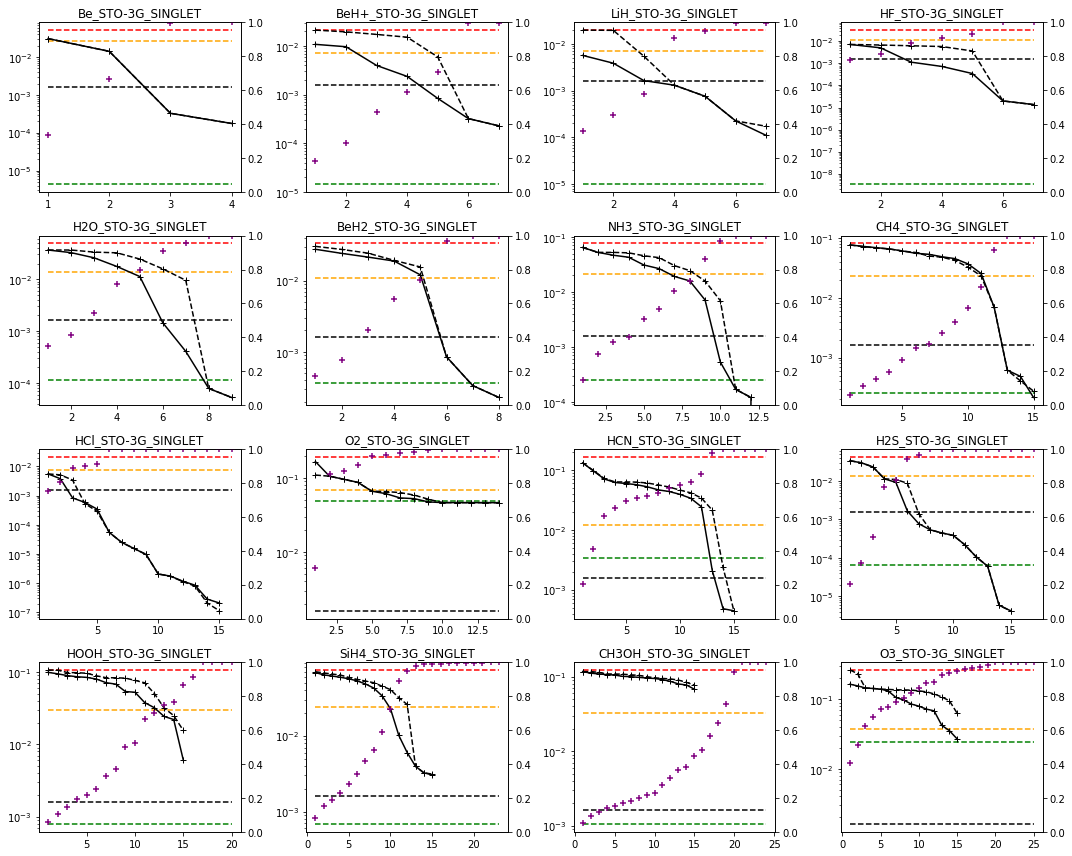

In [83]:
molecules = list(scoring_data_2.keys())
plot_mols = [mol for mol in molecules if scoring_data_2[mol]['fci_energy'] is not None]
mol_order = sorted([(mol, scoring_data_2[mol]['n_qubits_pre_taper']) for mol in plot_mols], key=lambda x:x[1])
mol_order, qubits = zip(*mol_order)

ncols, nrows = factor_near_square(len(plot_mols))
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15,12), sharey=False)

for speciesname, axis in zip(mol_order, fig.get_axes()):
    plot_energy_vs_score(speciesname, axis)

fig.tight_layout()
plt.show()

In [84]:
original={
    'H2O_STO-3G_SINGLET':7,
    'BeH+_STO-3G_SINGLET':'n/a',
    'LiH_STO-3G_SINGLET':4,
    'HF_STO-3G_SINGLET':4,
    'BeH2_STO-3G_SINGLET':7,
    'Be_STO-3G_SINGLET':3,
    'HCl_STO-3G_SINGLET':4,
    'NH3_STO-3G_SINGLET':11,
    'HCN_STO-3G_SINGLET':'n/a',
    'CH4_STO-3G_SINGLET':12,
    'CH3OH_STO-3G_SINGLET':'n/a',
    'SiH4_STO-3G_SINGLET':'n/a',
    'H2S_STO-3G_SINGLET':7,
    'HOOH_STO-3G_SINGLET':'n/a',
    'O3_STO-3G_SINGLET':'n/a',
    'O2_STO-3G_SINGLET':11
}

In [86]:
chem_acc_scores = []

for speciesname in mol_order:
    data = scoring_data_2[speciesname]
    n_qubits = data['n_qubits_post_taper']
    n_qubits_full = data['n_qubits_pre_taper']
    fci_energy = data['fci_energy']
    scores = data['stabilizer_score']
    cs_vqe_nrg = np.array(data['cs_vqe_energies'])[:15]-fci_energy
    try:
        index_chem_acc = np.where(cs_vqe_nrg<0.0016)[0][0]
        chem_acc_num_q = index_chem_acc+1
        chem_acc_scores.append(scores[index_chem_acc])
        frmat = speciesname[:speciesname.find('_')]
        orgnl = original[speciesname]
        if orgnl!='n/a':
            print(f'\ce{ {frmat} } & {n_qubits_full} & {n_qubits} & {chem_acc_num_q} & {orgnl} \\\\')
    except:
        pass
    
np.mean(chem_acc_scores)

\ce{'Be'} & 10 & 5 & 3 & 3 \\
\ce{'LiH'} & 12 & 8 & 4 & 4 \\
\ce{'HF'} & 12 & 8 & 3 & 4 \\
\ce{'H2O'} & 14 & 10 & 6 & 7 \\
\ce{'BeH2'} & 14 & 9 & 6 & 7 \\
\ce{'NH3'} & 16 & 14 & 10 & 11 \\
\ce{'CH4'} & 18 & 16 & 13 & 12 \\
\ce{'HCl'} & 20 & 17 & 3 & 4 \\
\ce{'H2S'} & 22 & 18 & 7 & 7 \\


0.926661773391844

# Plot the larger molecule scores for which FCI is too expensive

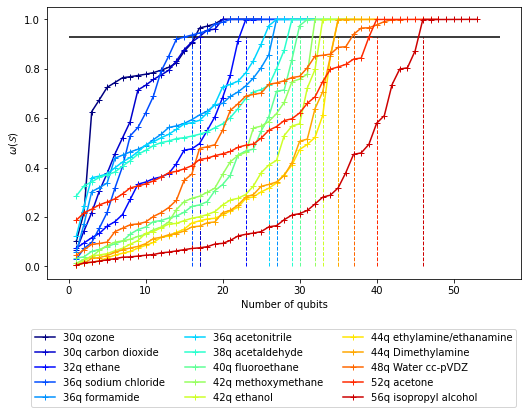

In [65]:
from matplotlib import cm

molecules = list(scoring_data_1.keys())

plot_mols = [mol for mol in molecules if scoring_data_1[mol]['n_qubits_pre_taper'] >=30]
mol_order = sorted([(mol, scoring_data_1[mol]['n_qubits_pre_taper']) for mol in plot_mols], key=lambda x:x[1])
mol_order, qubits = zip(*mol_order)

fig,score_axis = plt.subplots(figsize=(8.5,5))

for index, speciesname in enumerate(mol_order):
    try:
        name = molecule_geometries[speciesname]['name']
    except:
        name = 'Water cc-pVDZ'
    data = scoring_data_1[speciesname]
    n_qubits = data['n_qubits_post_taper']
    n_qubits_full = data['n_qubits_pre_taper']
    scores = np.square(np.array(data['stabilizer_score']))
    scored_1 = np.where(scores>0.93)[0][0]
    
    c = plt.cm.jet(index/len(plot_mols))
    X = np.arange(len(scores))+1
    score_axis.plot(X,scores, color=c, marker='+', label=f'{n_qubits_full}q {name}')
    score_axis.vlines(scored_1+1, 0, 0.93, color=c, ls='--', lw=1)

score_axis.hlines(0.93, 0, 56, color='black')
score_axis.set_xlabel('Number of qubits')
score_axis.set_ylabel('$\omega(\mathcal{S})$')
fig.legend(ncol=3, bbox_to_anchor=(0.9,0))
plt.show()

In [115]:
fig.savefig('plots/large_molecules.png', dpi=300, bbox_inches='tight')

In [61]:
for speciesname in mol_order:
    try:
        name = molecule_geometries[speciesname]['name']
    except:
        name = 'Water cc-pVDZ'
    name = name[0].upper() + name[1:]
    data = scoring_data_1[speciesname]
    n_qubits = data['n_qubits_post_taper']
    n_qubits_full = data['n_qubits_pre_taper']
    scores = np.square(np.array(data['stabilizer_score']))
    scored_1 = np.where(scores>0.93)[0][0]
    frmat = speciesname[:speciesname.find('_')]
    print(f'{name} & \ce{ {frmat} } & {n_qubits_full} & {n_qubits} & {scored_1} \\\\')

Ozone & \ce{'O3'} & 30 & 26 & 16 \\
Carbon dioxide & \ce{'CO2'} & 30 & 26 & 16 \\
Ethane & \ce{'C2H6'} & 32 & 28 & 22 \\
Sodium chloride & \ce{'NaCl'} & 36 & 33 & 15 \\
Formamide & \ce{'CHONH2'} & 36 & 33 & 26 \\
Acetonitrile & \ce{'CH3CN'} & 36 & 33 & 25 \\
Acetaldehyde & \ce{'CH3CHO'} & 38 & 35 & 28 \\
Fluoroethane & \ce{'C2H5F'} & 40 & 37 & 29 \\
Methoxymethane & \ce{'CH3OCH3'} & 42 & 38 & 31 \\
Ethanol & \ce{'CH3CH2OH'} & 42 & 39 & 32 \\
Ethylamine/ethanamine & \ce{'CH3CH2NH2'} & 44 & 41 & 34 \\
Dimethylamine & \ce{'CH3NHCH3'} & 44 & 41 & 34 \\
Water cc-pVDZ & \ce{'H2O'} & 48 & 44 & 36 \\
Acetone & \ce{'CH3COCH3'} & 52 & 49 & 39 \\
Isopropyl alcohol & \ce{'CH3CHOHCH3'} & 56 & 54 & 45 \\


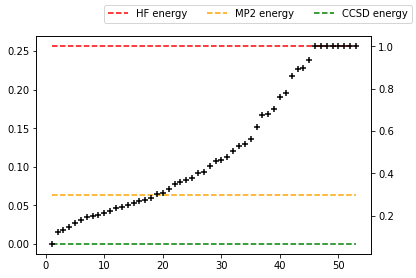

In [88]:
ref_energy = ccsd_energy

fig,energy_axis = plt.subplots()
X=np.arange(1, n_qubits)

Y_energy=np.array(energies)-ref_energy
energy_axis.plot(X[:0], Y_energy, color='black')
energy_axis.hlines(hf_energy-ref_energy, 1, X[-1], ls='--', color='red', label='HF energy')
energy_axis.hlines(mp2_energy-ref_energy, 1, X[-1], ls='--', color='orange', label='MP2 energy')
energy_axis.hlines(ccsd_energy-ref_energy, 1, X[-1], ls='--', color='green', label='CCSD energy')
#energy_axis.hlines(0.0016, 1, X[-1], ls='--', color='black', label='Chemical accuracy')

#energy_axis.set_ylim(1e-15, 1e-0) 
#energy_axis.set_yscale('log')

score_axis = energy_axis.twinx()
Y_scores=np.array(scores)
score_axis.scatter(X, Y_scores, color='black', marker='+')

#energy_axis.set_xticks(X)

fig.legend(ncol=4)
plt.show()

In [110]:
from scipy.special import comb

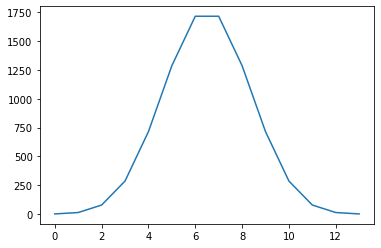

In [128]:
plt.plot([comb(13,x) for x in range(14)])

In [99]:
0.99**2

0.9801